# Apical Coactivity Analysis
## Notebook for preprocessing and analyzing coactivity spine data from apical FOVs

In [1]:
# Configure Notebook width
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# Import packages and modules
import os
import numpy as np
from Lab_Analyses.Spine_Analysis_v2 import spine_utilities as s_utils
from Lab_Analyses.Spine_Analysis_v2.preprocess_spine_data import organize_dual_spine_data
from Lab_Analyses.Spine_Analysis_v2.spine_activity_analysis import spine_activity_analysis
from Lab_Analyses.Spine_Analysis_v2.local_coactivity_analysis import local_coactivity_analysis
from Lab_Analyses.Spine_Analysis_v2.dendritic_coactivity_analysis import dendritic_coactivity_analysis
from Lab_Analyses.Spine_Analysis_v2.spine_volume_normalization import batch_spine_volume_normalization
## plotting modules
from Lab_Analyses.Spine_Analysis_v2 import spine_activity_plotting as spine_plotting
from Lab_Analyses.Spine_Analysis_v2 import dendrite_activity_plotting as dend_plotting
from Lab_Analyses.Spine_Analysis_v2 import local_coactivity_plotting as local_plotting

#%matplotlib ipympl
%matplotlib inline


## Datasets
Specify the mice the be analyzed and other analysis parameters

In [ ]:
# Mouse ids
id_1 = "JW082"
id_2 = "JW083" 
id_3 = "JW090"
id_4 = "JW092"
#id_5 = "JW126" # Not using
id_6 = "JW129" # No longer using FOV3
id_7 = "JW130" # Should I use? Nathan suspects layer 5?
id_8 = "JW153"
id_9 = "JW150"
id_10 = "JW168"

mouse_list = [id_1, id_2, id_3, id_4, id_6, id_7, id_8, id_9, id_10]

# FOV type
fov_type = "apical"

# Preprocessing parameters
reprocess = False
channels = {"GluSnFr": "GreenCh", "Calcium": "RedCh"}
redetection = True
followup=True
plot_norm=True

# Analysis parameters
activity_window = (-2,4) ## In seconds
zscore = False
volume_norm = True
extend_dendrite = False
cluster_dist = 5
days = ["Early", "Middle", "Late"]
movement_periods = [None, "movement", "nonmovement", "rewarded movement"]
#movement_periods = ["movement"]
partners = None
save_ind = False
save_grouped = True

## Preprocess data

In [ ]:
# Preprocess and reorganize the imaging datasets
for mouse in mouse_list:
    organize_dual_spine_data(
        mouse,
        channels=channels,
        fov_type=fov_type,
        redetection=redetection,
        reprocess=reprocess,
        save=True,
        followup=followup,
    )
    

# Generate volume normalization constants
if volume_norm:
    for day in days:
        ## GluSnFr data
        batch_spine_volume_normalization(
            mice_list=mouse_list,
            day=day,
            fov_type=fov_type,
            activity_type="GluSnFr",
            zscore=zscore,
            plot=plot_norm
        )
        ## Calcium data
        batch_spine_volume_normalization(
            mice_list=mouse_list,
            day=day,
            fov_type=fov_type,
            activity_type="Calcium",
            zscore=zscore,
            plot=plot_norm
        )

# Data Analysis

### Spine and dendrite activity analysis

In [ ]:
# Perform spine- and dendrite-centric analysis
for day in days:
    print(f"================ {day} =================")
    spine_activity_analysis(
        mice_list=mouse_list,
        session=day,
        fov_type=fov_type,
        activity_window=activity_window,
        zscore=zscore,
        volume_norm=volume_norm,
        save_ind=save_ind,
        save_grouped=save_grouped
    )
    print(f"======================================")

### Local coactivity analysis

In [ ]:
# Perform local coactivity analysis
for day in days:
    print(f" {day} ".center(40, "#"))
    for movement in movement_periods:
        if movement is None:
            print(" ALL PERIODS ".center(40,"="))
        else:
            print(f" {movement.upper()} ".center(40,"="))
        local_coactivity_analysis(
            mice_list=mouse_list,
            session=day,
            fov_type=fov_type,
            activity_window=activity_window,
            cluster_dist=cluster_dist,
            zscore=zscore,
            volume_norm=volume_norm,
            partners=partners,
            movement_period=movement,
            save_ind=save_ind,
            save_grouped=save_grouped
        )
        print("========================================")
    print(f"########################################")

### Spine-dendrite coactivity analysis

In [ ]:
# Perform the dendritic coactivity analysis
for day in days:
    print(f"================ day =================")
    for movement in movement_periods:
        print(f"- {movement.upper()})
        dendritic_coactivity_analysis(
            mice_list=mouse_list,
            session=day,
            fov_type=fov_type,
            activity_window=activity_window,
            cluster_dist=cluster_dist,
            zscore=zscore,
            volume_norm=volume_norm,
            partners=partners,
            movement_period=movement_period,
            extend=extend_dendrite,
            save_ind=save_ind,
            save_grouped=save_grouped,
        )
    print(f"======================================")

# Visualize analyzed data

In [3]:
# Set up file and path information
## Select session to analyze
load_session = "Early"
## Set path the save figures in
figure_path = r"C:\Users\Jake\Desktop\Figures\grouped_data\Dual_Spine_Imaging\Coactivity_Plasticity"
save_path = os.path.join(figure_path, load_session)
## Ensure the path exists
if not os.path.isdir(save_path):
    os.makedirs(save_path)

In [4]:
# General properties
exclude = "Shaft Spine"
threshold = 0.3
mean_type = "median"
err_type = "CI"
test_type = "nonparametric"
test_method = "holm-sidak"
display_stats = True

## Spine and Dendrite Activity

In [ ]:
# Load specified datasets
activity_data = s_utils.load_analyzed_datasets(
    type="Activity",
    grouped=True,
    session="Early",
    norm=True,
    activity_type="dFoF",
    extended=None,
    mouse=None,
    fov=None,
    fov_type="apical",
    period=None,
    partner=None,
)

In [ ]:
print(len(activity_data.spine_volumes[~np.isnan(activity_data.spine_volumes)]))

### Figure 1 - Basic Spine Features

In [ ]:
# Figure 1 - Basic spine features
spine_plotting.plot_basic_features(
    dataset=activity_data,
    followup_dataset=None,
    exclude=exclude,
    threshold=threshold,
    figsize=(10,7),
    hist_bins=35,
    showmeans=False,
    test_type=test_type,
    test_method=test_method,
    display_stats=display_stats,
    save=True,
    save_path=figure_path
)

### Figure 2 - Movement-related activity

In [ ]:
spine_plotting.plot_movement_related_activity(
    dataset=activity_data,
    followup_dataset=None,
    exclude=exclude,
    threshold=threshold,
    figsize=(12,12),
    hist_bins=20,
    showmeans=False,
    test_type=test_type,
    test_method=test_method,
    display_stats=display_stats,
    save=False,
    save_path=figure_path
)

### Figure 3 - Rewarded movement-related activity

In [ ]:
spine_plotting.plot_rewarded_movement_related_activity(
    dataset=activity_data,
    followup_dataset=None,
    exclude=exclude,
    threshold=threshold,
    figsize=(14,10),
    hist_bins=20,
    showmeans=False,
    test_type=test_type,
    test_method=test_method,
    display_stats=display_stats,
    save=False,
    save_path=figure_path
)

### Figure 4 - Spine movement encoding

In [ ]:
spine_plotting.plot_spine_movement_encoding(
    dataset=activity_data,
    followup_dataset=None,
    exclude=exclude,
    threshold=threshold,
    figsize=(11, 10),
    showmeans=False,
    test_type=test_type,
    test_method=test_method,
    display_stats=display_stats,
    save=True,
    save_path=figure_path,
)

### Figure 5 - Dendrite activity features

In [ ]:
dend_plotting.plot_activity_features(
    dataset=activity_data,
    followup_dataset=None,
    exclude=exclude,
    threshold=threshold,
    figsize=(14, 12),
    hist_bins=10,
    save=False,
    save_path=figure_path,
)

### Figure 6 - Dendrite movement encoding

In [ ]:
dend_plotting.plot_dendrite_movement_encoding(
    dataset=activity_data,
    followup_dataset=None,
    exclude=exclude,
    threshold=threshold,
    figsize=(12, 15),
    save=False,
    save_path=figure_path,
)

## Local Spine Coactivity

In [5]:
# Load specified datasets
## Entire session
all_coactivity_data = s_utils.load_analyzed_datasets(
    type="Local",
    grouped=True,
    session="Early",
    norm=True,
    activity_type="dFoF",
    extended=None,
    mouse=None,
    fov=None,
    fov_type="apical",
    period=None,
    partner=None,
)
## Mvmt periods only
mvmt_coactivity_data = s_utils.load_analyzed_datasets(
    type="Local",
    grouped=True,
    session="Early",
    norm=True,
    activity_type="dFoF",
    extended=None,
    mouse=None,
    fov=None,
    fov_type="apical",
    period="movement",
    partner=None,
)
## Nonmvmt periods only
nonmvmt_coactivity_data = s_utils.load_analyzed_datasets(
    type="Local",
    grouped=True,
    session="Early",
    norm=True,
    activity_type="dFoF",
    extended=None,
    mouse=None,
    fov=None,
    fov_type="apical",
    period="nonmovement",
    partner=None,
)

### Figure 1 Coactive vs Non-coactive events

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\Jake\\Desktop\\Figures\\grouped_data\\Dual_Spine_Imaging\\Coactivity_Plasticity\\Local_Coactivity_Figure_1.pdf'

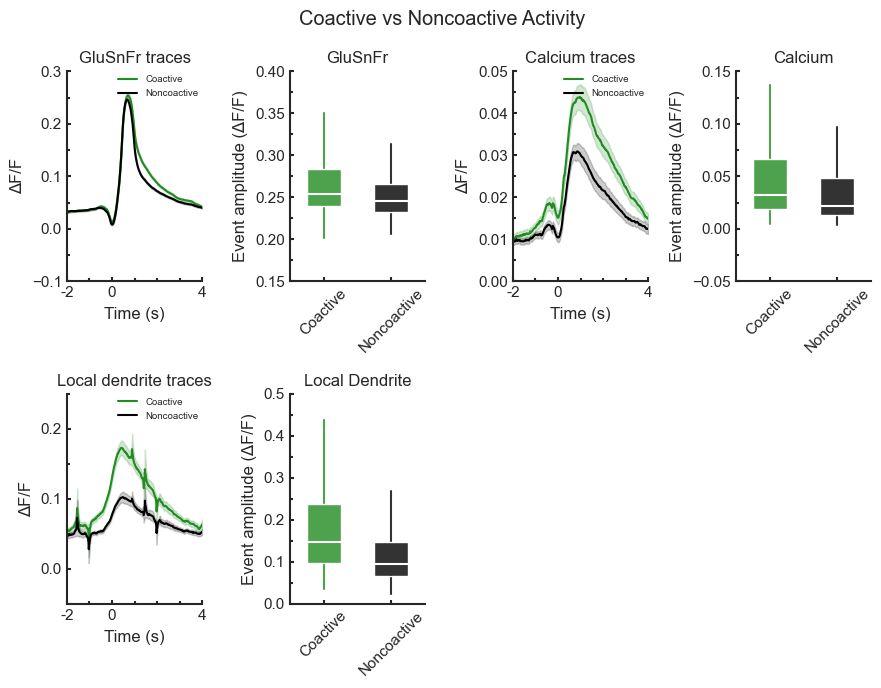

In [6]:
local_plotting.plot_coactive_vs_noncoactive_events(
    dataset=all_coactivity_data,
    figsize=(9, 7),
    showmeans=False,
    test_type=test_type,
    display_stats=True,
    save=True,
    save_path=figure_path
)

### Figure 2 Mvmt vs Non-mvmt coactivity

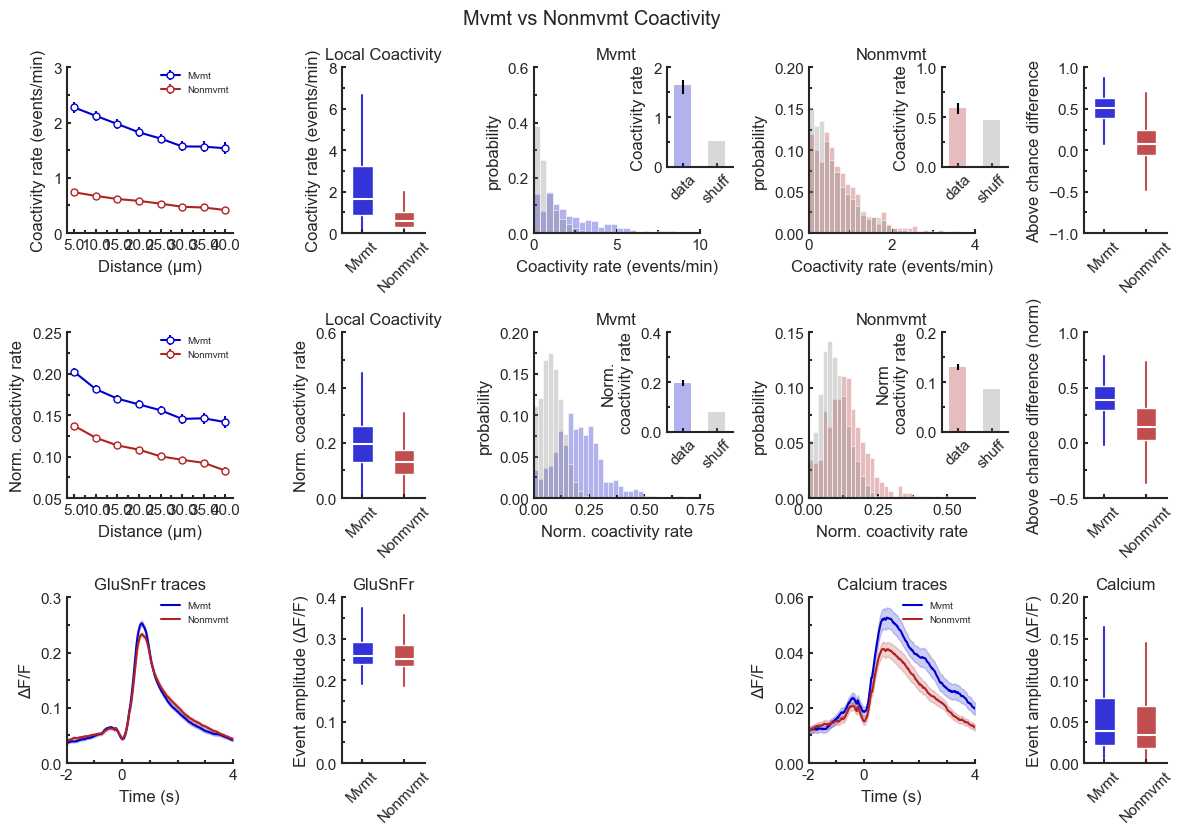

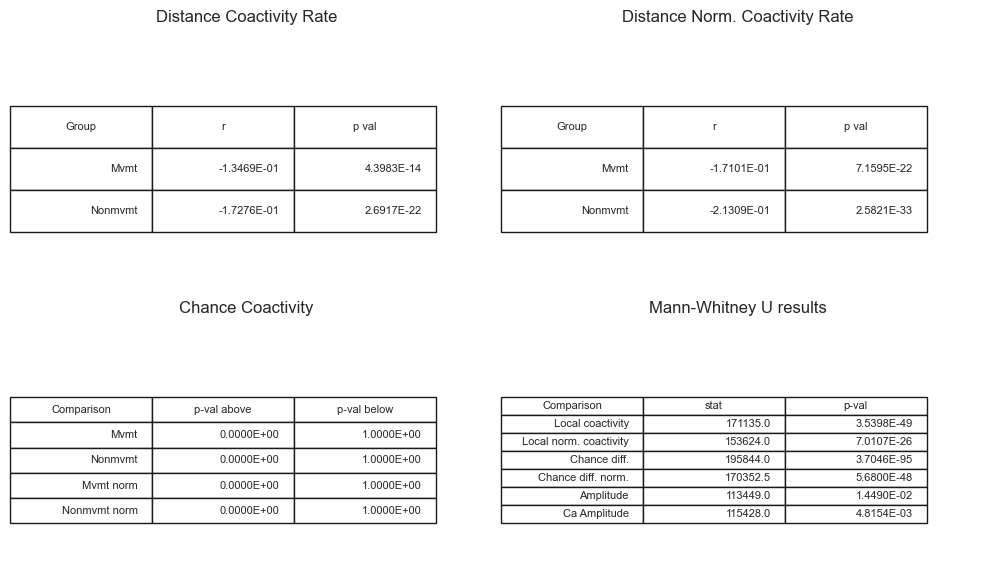

In [7]:
local_plotting.plot_comparative_mvmt_coactivity(
    mvmt_dataset=mvmt_coactivity_data,
    nonmvmt_dataset=nonmvmt_coactivity_data,
    rwd_mvmts=False,
    figsize=(12,8.5),
    showmeans=False,
    mean_type=mean_type,
    err_type=err_type,
    hist_bins=30,
    test_type=test_type,
    display_stats=display_stats,
    save=True,
    save_path=figure_path
)

In [ ]:
import numpy as np

a = np.array([1,2,3,4,2,1,3,5,np.nan,3,2])
b = 4

np.nansum(a <= b) / len(a)